In [ ]:
# @title 0) Setup: installs & imports
!pip -q install datasets transformers fastai scikit-learn torchtext

import os, random, math, numpy as np, torch, pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load IMDB (25k train, 25k test)
ds = load_dataset("imdb")
train_df = ds["train"].to_pandas()
test_df  = ds["test"].to_pandas()
train_df.rename(columns={"text":"text","label":"label"}, inplace=True)
test_df.rename(columns={"text":"text","label":"label"}, inplace=True)

# Optional: subsample for quicker demo (uncomment to speed up)
# train_df = train_df.sample(20000, random_state=SEED).reset_index(drop=True)
# test_df  = test_df.sample(5000,  random_state=SEED).reset_index(drop=True)

print(f"Train: {len(train_df)}, Test: {len(test_df)}, Device: {device}")

Train: 25000, Test: 25000, Device: cuda


In [ ]:
# 1) TF-IDF + RandomForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english", lowercase=True)
X_tr = tfidf.fit_transform(train_df.text.values)
X_te = tfidf.transform(test_df.text.values)
y_tr = train_df.label.values
y_te = test_df.label.values

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
acc_tfidf_rf = accuracy_score(y_te, pred)
print("TF-IDF + RF accuracy:", acc_tfidf_rf)

TF-IDF + RF accuracy: 0.8562


In [ ]:
# 2) LSA (Truncated SVD) + RandomForest
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

lsa_rf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english", lowercase=True)),
    ("svd", TruncatedSVD(n_components=300, random_state=SEED)),
    ("rf", RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED))
])
lsa_rf.fit(train_df.text.values, y_tr)
pred = lsa_rf.predict(test_df.text.values)
acc_lsa_rf = accuracy_score(y_te, pred)
print("LSA + RF accuracy:", acc_lsa_rf)


LSA + RF accuracy: 0.80488


In [ ]:
# Stacked Bi‑LSTM (PyTorch) (2 layers, bidirectional)
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

def basic_tokenize(s):
    s = s.lower()
    return re.findall(r"[a-z0-9]+", s)

# Build vocab
MAX_VOCAB = 20000
PAD, UNK = "<pad>", "<unk>"

counter = Counter()
for txt in train_df.text.values:
    counter.update(basic_tokenize(txt))
vocab = [PAD, UNK] + [w for w,_ in counter.most_common(MAX_VOCAB-2)]
stoi = {w:i for i,w in enumerate(vocab)}

def encode(text, max_len=256):
    ids = [stoi.get(tok, stoi[UNK]) for tok in basic_tokenize(text)]
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [stoi[PAD]]*(max_len-len(ids))
    return np.array(ids, dtype=np.int64)

class TextDS(Dataset):
    def __init__(self, df, max_len=256):
        self.x = [encode(t, max_len) for t in df.text.values]
        self.y = df.label.values.astype(np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return torch.tensor(self.x[i]), torch.tensor(self.y[i])

train_ds_lstm = TextDS(train_df, max_len=256)
test_ds_lstm  = TextDS(test_df,  max_len=256)

BATCH=64
train_dl = DataLoader(train_ds_lstm, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds_lstm,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden=128, layers=2, bidir=True, num_classes=2, pad_idx=0, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden, num_layers=layers, batch_first=True, bidirectional=bidir, dropout=dropout)
        out_dim = hidden * (2 if bidir else 1)
        self.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(out_dim, num_classes))
    def forward(self, x):
        e = self.emb(x)                        # [B,T,E]
        h,_ = self.lstm(e)                     # [B,T,H*dir]
        # take last timestep OR max-pool; here we use max-pool for robustness
        pooled,_ = torch.max(h, dim=1)         # [B,H*dir]
        return self.fc(pooled)

model_lstm = BiLSTMClassifier(len(vocab)).to(device)
opt = torch.optim.AdamW(model_lstm.parameters(), lr=2e-3)
crit = nn.CrossEntropyLoss()

def train_epochs(model, epochs=2):
    model.train()
    for ep in range(epochs):
        total, correct, n = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += loss.item()*xb.size(0)
            pred = logits.argmax(1)
            correct += (pred==yb).sum().item(); n += xb.size(0)
        print(f"Epoch {ep+1}: loss={total/n:.4f}, acc={correct/n:.4f}")

@torch.no_grad()
def eval_acc(model):
    model.eval()
    preds, gold = [], []
    for xb,yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        gold.append(yb.numpy())
    preds = np.concatenate(preds); gold = np.concatenate(gold)
    return accuracy_score(gold, preds)

train_epochs(model_lstm, epochs=2)
acc_bilstm = eval_acc(model_lstm)
print("Bi-LSTM accuracy:", acc_bilstm)

Epoch 1: loss=0.4710, acc=0.7579
Epoch 2: loss=0.2562, acc=0.8956
Bi-LSTM accuracy: 0.881


In [ ]:
# Small Transformer Encoder (3 layers) + Max Pool
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, num_layers=3, dim_ff=256, num_classes=2, pad_idx=0, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=dim_ff, batch_first=True, dropout=dropout, activation="gelu")
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(emb_dim, num_classes))
    def forward(self, x):
        mask = (x == stoi[PAD])             # [B,T]
        e = self.emb(x)                     # [B,T,E]
        z = self.encoder(e, src_key_padding_mask=mask)
        z = self.norm(z)
        pooled,_ = torch.max(z.masked_fill(mask.unsqueeze(-1), -1e9), dim=1)  # max-pool over T
        return self.head(pooled)

model_tx = TransformerClassifier(len(vocab)).to(device)
opt_tx = torch.optim.AdamW(model_tx.parameters(), lr=2e-3, weight_decay=1e-2)
crit = nn.CrossEntropyLoss()

def train_epochs_tx(model, epochs=2):
    model.train()
    for ep in range(epochs):
        total, correct, n = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt_tx.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt_tx.step()
            total += loss.item()*xb.size(0)
            pred = logits.argmax(1)
            correct += (pred==yb).sum().item(); n += xb.size(0)
        print(f"[TX] Epoch {ep+1}: loss={total/n:.4f}, acc={correct/n:.4f}")

@torch.no_grad()
def eval_acc_tx(model):
    model.eval()
    preds, gold = [], []
    for xb,yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        gold.append(yb.numpy())
    preds = np.concatenate(preds); gold = np.concatenate(gold)
    return accuracy_score(gold, preds)

train_epochs_tx(model_tx, epochs=2)
acc_tx = eval_acc_tx(model_tx)
print("Transformer(3L)+MaxPool accuracy:", acc_tx)


[TX] Epoch 1: loss=0.4859, acc=0.7659
[TX] Epoch 2: loss=0.3122, acc=0.8724


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Transformer(3L)+MaxPool accuracy: 0.85156


In [ ]:
# ULMFiT (fastai AWD-LSTM) fine-tune
from fastai.text.all import *

# Prepare fastai DataLoaders (train/valid from official train, then test_dl for official test)
df_tr = train_df.copy()
df_te = test_df.copy()
df_tr["is_valid"] = False
# create a small validation from train set for monitoring
tr_idx, va_idx = train_test_split(np.arange(len(df_tr)), test_size=0.1, random_state=SEED, stratify=df_tr.label)
df_tr.loc[va_idx, "is_valid"] = True

dls = TextDataLoaders.from_df(df=df_tr, text_col="text", label_col="label", is_valid_col="is_valid",
                              bs=64, seq_len=72)  # smaller seq_len for speed

learn = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)
learn.fine_tune(1)

# Evaluate on official test set
test_dl = dls.test_dl(df_te["text"].values)
preds, _ = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(1).numpy()
acc_ulmfit = accuracy_score(df_te["label"].values, pred_labels)
print("ULMFiT (AWD-LSTM) accuracy:", acc_ulmfit)


epoch,train_loss,valid_loss,accuracy,time
0,0.466327,0.389576,0.830800,01:42


epoch,train_loss,valid_loss,accuracy,time
0,0.357900,0.275442,0.888600,04:25


ULMFiT (AWD-LSTM) accuracy: 0.8818


In [ ]:
!pip install -U transformers accelerate
!pip -q install evaluate

In [ ]:
# 6) DistilBERT fine-tune (HF Trainer)
# DistilBERT fine-tune (compatible with older Transformers)
import numpy as np, torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from datasets import Dataset as HFDataset, DatasetDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use your existing train_df/test_df; if not present, raise a clear error
assert 'train_df' in globals() and 'test_df' in globals(), "Run the setup cell that creates train_df/test_df first."

# Build HF datasets from pandas
hf_ds = DatasetDict({
    "train": HFDataset.from_pandas(train_df[["text","label"]].reset_index(drop=True)),
    "test":  HFDataset.from_pandas(test_df[["text","label"]].reset_index(drop=True))
})

# Tokenizer & tokenization
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tok_ds = hf_ds.map(lambda b: tokenizer(b["text"], truncation=True, max_length=256),
                   batched=True, remove_columns=["text"])
tok_ds = tok_ds.rename_column("label", "labels")
tok_ds = tok_ds.remove_columns([c for c in tok_ds["train"].column_names
                                if c not in ["input_ids","attention_mask","labels"]])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2).to(device)

# Training args (no evaluation_strategy)
train_args = TrainingArguments(
    output_dir="./distilbert_imdb",
    do_eval=True,                       # older API uses this flag
    per_device_train_batch_size=16 if device.type=="cuda" else 8,
    per_device_eval_batch_size=32 if device.type=="cuda" else 16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    fp16=(device.type=="cuda"),
    report_to=[]
)

# Simple accuracy metric without extra deps
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": float((preds == labels).mean())}

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
eval_res = trainer.evaluate(tok_ds["test"])
acc_distilbert = float(eval_res.get("eval_accuracy", 0.0))
print("DistilBERT accuracy:", acc_distilbert)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3601153909.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.464500
200,0.319800
300,0.333400
400,0.294700
500,0.285100
600,0.279500
700,0.294300
800,0.270000
900,0.238700
1000,0.295900


DistilBERT accuracy: 0.91256


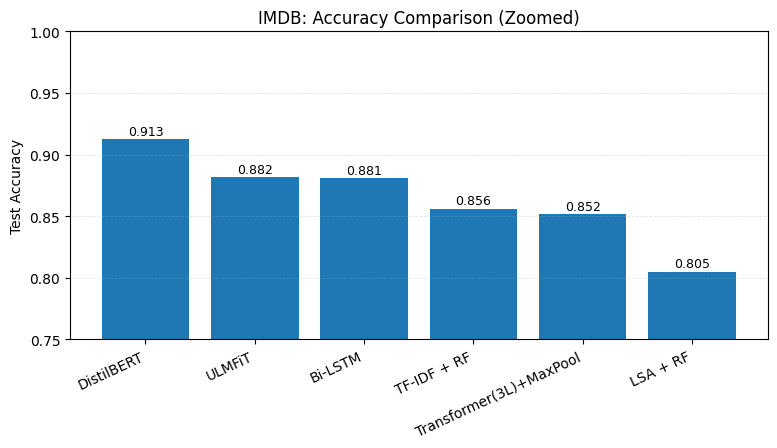

In [ ]:
# @title 7b) Accuracy Comparison (zoomed to 0.75–1.00)
import numpy as np
import matplotlib.pyplot as plt

# Reuse existing 'accs' if present; otherwise rebuild from variables
try:
    accs
except NameError:
    accs = {
        "TF-IDF + RF": float(acc_tfidf_rf),
        "LSA + RF": float(acc_lsa_rf),
        "Bi-LSTM": float(acc_bilstm),
        "Transformer(3L)+MaxPool": float(acc_tx),
        "ULMFiT": float(acc_ulmfit),
        "DistilBERT": float(acc_distilbert),
    }

# Sort by accuracy (desc) for readability
labels, values = zip(*sorted(accs.items(), key=lambda kv: kv[1], reverse=True))

plt.figure(figsize=(9,4))
bars = plt.bar(labels, values)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Test Accuracy")
plt.title("IMDB: Accuracy Comparison (Zoomed)")
plt.ylim(0.75, 1.00)                     # << zoomed range
plt.yticks(np.linspace(0.75, 1.00, 6))   # 0.75, 0.80, ..., 1.00
plt.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.6)

# Add value labels on bars
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.001, f"{h:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.show()
